In [1]:
# Regular EDA (exploratory data analysis) and plotting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
import warnings
import rdkit
import mols2grid
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import rdmolops
from rdkit.Chem import Descriptors, AllChem, rdMolDescriptors, rdCoordGen
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG=True
%matplotlib inline 

# ML models
import torch
from torch.nn import Linear, Dropout
import torch.nn as nn
import torch.optim as optim
import torch_geometric
from torch.optim.lr_scheduler import StepLR
from torch_geometric.data import Data, Dataset
from torch_geometric.nn import GCNConv, TopKPooling, global_max_pool, global_mean_pool
from torch_geometric.nn import GINConv
from torch_geometric.nn import GlobalAttention
from torch_geometric.loader import DataLoader
from torch.utils.data import random_split
from torch_geometric.utils import to_networkx
from torch_geometric.utils import from_smiles
from torch_geometric.nn import AttentiveFP
import torch.nn.functional as F
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score, mean_absolute_error, mean_squared_error

In [2]:
# Set the seed value
random_seed = 50

# Ensure reproducibility across PyTorch (CPU & GPU)
torch.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)

# Ensure reproducibility for NumPy
np.random.seed(random_seed)

# Ensure deterministic behavior in PyTorch operations
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
df = pd.read_csv("cleaned_BBBP.csv")
df.shape

(2039, 2)

In [4]:
df

,smiles,p_np
0,[Cl].CC(C)NCC(O)COc1cccc2ccccc12,1
1,C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl,1
2,c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...,1
3,C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C,1
4,Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)...,1
...,...,...
2034,C1=C(Cl)C(=C(C2=C1NC(=O)C(N2)=O)[N+](=O)[O-])Cl,1
2035,[C@H]3([N]2C1=C(C(=NC=N1)N)N=C2)[C@@H]([C@@H](...,1
2036,[O+]1=N[N](C=C1[N-]C(NC2=CC=CC=C2)=O)C(CC3=CC=...,1
2037,C1=C(OC)C(=CC2=C1C(=[N+](C(=C2CC)C)[NH-])C3=CC...,1


In [5]:
# Visualising Chemicals
smiles_list = df['smiles'].to_list()
chems = [rdkit.Chem.MolFromSmiles(x) for x in smiles_list]
chems = [mol for mol in chems if mol is not None]
mols2grid.display(chems)

[19:46:14] WARNING: not removing hydrogen atom without neighbors
[19:46:14] WARNING: not removing hydrogen atom without neighbors
[19:46:14] WARNING: not removing hydrogen atom without neighbors
[19:46:14] WARNING: not removing hydrogen atom without neighbors
[19:46:14] WARNING: not removing hydrogen atom without neighbors
[19:46:14] WARNING: not removing hydrogen atom without neighbors
[19:46:14] WARNING: not removing hydrogen atom without neighbors
[19:46:14] WARNING: not removing hydrogen atom without neighbors
[19:46:14] WARNING: not removing hydrogen atom without neighbors
[19:46:14] WARNING: not removing hydrogen atom without neighbors
[19:46:14] WARNING: not removing hydrogen atom without neighbors
[19:46:14] WARNING: not removing hydrogen atom without neighbors
[19:46:14] WARNING: not removing hydrogen atom without neighbors
[19:46:14] WARNING: not removing hydrogen atom without neighbors
[19:46:14] WARNING: not removing hydrogen atom without neighbors
[19:46:14] WARNING: not r

MolGridWidget()

In [6]:
def calculate_descriptors(mol):
    if mol is None:
        return torch.zeros(1, 6, dtype=torch.float)
    
    descriptors = [
        Descriptors.MolWt(mol),                    # Molecular weight
        Descriptors.Chi0(mol),                     # Chi0 descriptor
        Descriptors.TPSA(mol),                     # Topological Polar Surface Area
        Descriptors.NumHDonors(mol),               # Number of Hydrogen Bond Donors
        Descriptors.MolLogP(mol),                  # LogP (lipophilicity)
        Descriptors.NumHAcceptors(mol),            # Number of Hydrogen Bond Acceptors
    ]
    
    return torch.tensor(descriptors, dtype=torch.float).view(1, -1)

In [7]:
# Initialize an empty list to store the graphs
graph_list = []

# Iterate over each SMILES string in the DataFrame
for i, smile in enumerate(df['smiles']):
    # Generate the graph from the SMILES string
    g = from_smiles(smile)
    
    # Ensure that the node features are in float format
    g.x = g.x.float()
    
    # Compute descriptors and convert to tensor
    mol = Chem.MolFromSmiles(smile)
    descriptor_tensor = calculate_descriptors(mol)
    
    # Create a tensor for the target value and reshape it
    y = torch.tensor(df['p_np'][i], dtype=torch.float).view(1, -1)
    
    # Assign tensors to the graph
    g.y = y
    g.descriptors = descriptor_tensor  # Store descriptor tensor
    
    # Append the processed graph to the list
    graph_list.append(g)

In [8]:
graph_list[0]

Data(x=[20, 9], edge_index=[2, 40], edge_attr=[40, 3], smiles='[Cl].CC(C)NCC(O)COc1cccc2ccccc12', y=[1, 1], descriptors=[1, 6])

In [9]:
# Define the ratio for splitting the dataset (80% for training, 20% for validation)
train_ratio = 0.80

# Calculate the total number of samples in the dataset
dataset_size = len(graph_list)

# Calculate the number of samples for the training and validation sets
train_size = int(train_ratio * dataset_size)
val_size = dataset_size - train_size

# Set a random seed for reproducibility
random_seed = 66
generator = torch.Generator().manual_seed(random_seed)

# Split the dataset into training and validation subsets
train_dataset, val_dataset = random_split(graph_list, [train_size, val_size], generator=generator)

In [10]:
# Create the DataLoaders for the train and val sets
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

In [11]:
class HybridGIN(nn.Module):
    def __init__(self, hidden_channels, descriptor_size, dropout_rate):
        super(HybridGIN, self).__init__()

        # GIN layers (MLP inside each GINConv)
        self.initial_conv = GINConv(Linear(9, hidden_channels))
        self.conv1 = GINConv(Linear(hidden_channels, hidden_channels))
        self.conv2 = GINConv(Linear(hidden_channels, hidden_channels))
        self.conv3 = GINConv(Linear(hidden_channels, hidden_channels))

        # Fully connected layers for hybrid model
        self.fc1 = Linear(hidden_channels * 2 + descriptor_size, 128)
        self.fc2 = Linear(128, 64)
        self.out = Linear(64, 1)  # Single output unit for binary classification

        # GELU Activation
        self.gelu = nn.GELU()

        # Dropout
        self.dropout = Dropout(p=dropout_rate)

    def forward(self, x, edge_index, batch_index, descriptors):
        hidden = self.gelu(self.initial_conv(x, edge_index))
        hidden = self.gelu(self.conv1(hidden, edge_index))
        hidden = self.gelu(self.conv2(hidden, edge_index))
        hidden = self.gelu(self.conv3(hidden, edge_index))

        # Global Pooling
        hidden = torch.cat([global_max_pool(hidden, batch_index), 
                            global_mean_pool(hidden, batch_index)], dim=1)

        # Ensure descriptors are of shape (batch_size, descriptor_size)
        if descriptors.dim() == 1:
            descriptors = descriptors.unsqueeze(1)  

        # Concatenate descriptors with graph embeddings
        hybrid_features = torch.cat([hidden, descriptors], dim=1)

        # Fully connected layers with Dropout
        out = self.gelu(self.fc1(hybrid_features))
        out = self.dropout(out)  # Dropout before second FC layer

        out = self.gelu(self.fc2(out))
        out = self.dropout(out)  # Dropout before output layer

        out = self.out(out)  # Final output (logits, not probabilities)

        return out, hybrid_features  # Output and final feature representation

In [12]:
# Set up the device (GPU if available, otherwise CPU) and initialize the model and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model with specified parameters and move it to the appropriate device
model = HybridGIN(hidden_channels=128, descriptor_size=6, dropout_rate=0.65).to(device)

# Set up the NAdam optimizer with learning rate and weight decay for regularization
optimizer = torch.optim.NAdam(model.parameters(), lr=0.0008, weight_decay=0.0)

# Set up a Scheduler
scheduler = StepLR(optimizer, step_size=15, gamma=0.8)

In [13]:
def train():
    model.train()  # Set model to training mode
    total_loss = total_samples = total_correct = 0
    y_true = []  # True labels
    y_pred = []  # Predicted probabilities

    for data in train_loader:
        data = data.to(device)  # Move data to the correct device (GPU/CPU)
        
        optimizer.zero_grad()  # Zero out gradients
        
        # Forward pass through the model
        out, _ = model(data.x, data.edge_index, data.batch, data.descriptors)
        
        # Reshape output to be (batch_size,)
        out = out.view(-1)  # Remove the extra dimension for the output
        
        # Squeeze target to make it a 1D tensor of shape [batch_size]
        target = data.y.view(-1)  # Flatten target to match the output
        
        # Calculate loss (Binary Cross-Entropy with logits)
        loss = F.binary_cross_entropy_with_logits(out, target.float())
        
        # Backpropagate loss and update the model parameters
        loss.backward()
        optimizer.step()
        
        # Accumulate the loss and correct predictions
        total_loss += float(loss) * data.num_graphs
        total_samples += data.num_graphs
        
        # Store true labels and predicted probabilities for AUC calculation
        y_true.append(target.cpu().numpy())
        y_pred.append(torch.sigmoid(out).cpu().detach().numpy())  # Use sigmoid to get probabilities
        
        # Calculate accuracy
        pred = (torch.sigmoid(out) > 0.5).float()  # Apply threshold to logits
        correct = (pred == target.float()).sum().item()  # Count correct predictions
        total_correct += correct
    
    # Flatten the lists for AUC calculation
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    
    # Calculate AUC
    auc = roc_auc_score(y_true, y_pred)
    
    # Calculate accuracy
    accuracy = total_correct / total_samples * 100
    
    # Return AUC and accuracy
    return auc, accuracy

In [14]:
@torch.no_grad()  # Disable gradient computation for evaluation
def val(loader):
    total_loss = total_samples = total_correct = 0
    y_true = []  # Store true labels for AUC
    y_pred = []  # Store predicted probabilities for AUC
    
    model.eval()  # Set model to evaluation mode
    
    for data in loader:
        data = data.to(device)  # Move data to the device
        
        # Forward pass
        out, _ = model(data.x, data.edge_index, data.batch, data.descriptors)
        
        # Reshape output to be (batch_size,)
        out = out.view(-1)  # Remove the extra dimension for the output
        
        # Squeeze target to make it a 1D tensor of shape [batch_size]
        target = data.y.view(-1)  # Flatten target to match the output
        
        # Calculate loss (Binary Cross-Entropy with logits)
        loss = F.binary_cross_entropy_with_logits(out, target.float())
        
        # Accumulate loss and correct predictions
        total_loss += float(loss) * data.num_graphs
        total_samples += data.num_graphs
        
        # Calculate accuracy
        pred = (torch.sigmoid(out) > 0.5).float()  # Apply threshold to logits
        correct = (pred == target.float()).sum().item()  # Count correct predictions
        total_correct += correct
        
        # Store the true labels and predicted probabilities for AUC calculation
        y_true.append(target.cpu().numpy())
        y_pred.append(torch.sigmoid(out).cpu().detach().numpy())  # Use sigmoid to get probabilities
    
    # Flatten the lists for AUC calculation
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    
    # Calculate AUC
    auc = roc_auc_score(y_true, y_pred)
    
    # Calculate accuracy
    accuracy = total_correct / total_samples * 100
    
    return auc, accuracy

In [15]:
# Ignore warnings (you might not need this, but keeping as per your original code)
warnings.filterwarnings("ignore", category=UserWarning)

# Initialize lists to store training and validation scores (AUC and accuracy)
score_train_auc = []
score_train_acc = []
score_val_auc = []
score_val_acc = []

epochs = 150

# Loop over each epoch for training
for epoch in range(epochs):
    
    # Train the model and get the training AUC and accuracy
    train_auc, train_accuracy = train()

    # Adjust learning rate
    scheduler.step()

    # Validate the model and get the validation AUC and accuracy
    val_auc, val_accuracy = val(val_loader)

    # Append the AUC and accuracy to their respective lists
    score_train_auc.append(train_auc)
    score_train_acc.append(train_accuracy)
    score_val_auc.append(val_auc)
    score_val_acc.append(val_accuracy)

    # Print the progress of the training process (epoch number, AUC, and accuracy)
    print(f'Epoch: {epoch+1}/{epochs} | '
          f'AUC: {train_auc:.4f}, Accuracy: {train_accuracy:.2f}%, '
          f'Val AUC: {val_auc:.4f}, Val Accuracy: {val_accuracy:.2f}%')

Epoch: 1/150 | Train AUC: 0.5753, Train Accuracy: 70.14%, Val AUC: 0.7539, Val Accuracy: 80.64%
Epoch: 2/150 | Train AUC: 0.6782, Train Accuracy: 76.09%, Val AUC: 0.7773, Val Accuracy: 83.82%
Epoch: 3/150 | Train AUC: 0.6761, Train Accuracy: 77.93%, Val AUC: 0.7686, Val Accuracy: 82.60%
Epoch: 4/150 | Train AUC: 0.7301, Train Accuracy: 78.79%, Val AUC: 0.8027, Val Accuracy: 82.11%
Epoch: 5/150 | Train AUC: 0.7584, Train Accuracy: 80.44%, Val AUC: 0.7962, Val Accuracy: 82.35%
Epoch: 6/150 | Train AUC: 0.7645, Train Accuracy: 80.87%, Val AUC: 0.8079, Val Accuracy: 83.33%
Epoch: 7/150 | Train AUC: 0.7868, Train Accuracy: 81.30%, Val AUC: 0.8121, Val Accuracy: 82.35%
Epoch: 8/150 | Train AUC: 0.7785, Train Accuracy: 80.56%, Val AUC: 0.8115, Val Accuracy: 83.09%
Epoch: 9/150 | Train AUC: 0.7899, Train Accuracy: 81.12%, Val AUC: 0.8119, Val Accuracy: 83.82%
Epoch: 10/150 | Train AUC: 0.7925, Train Accuracy: 82.83%, Val AUC: 0.8171, Val Accuracy: 84.80%
Epoch: 11/150 | Train AUC: 0.8069, Trai

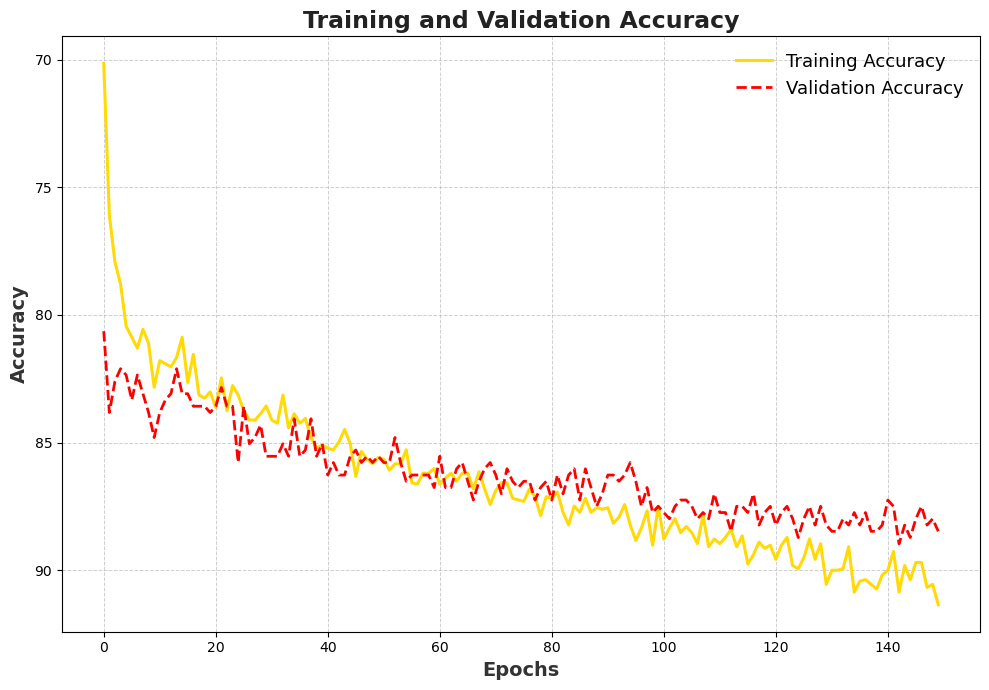

In [16]:
# Choose a style for the plot
plt.style.use("default")

# Create figure
plt.figure(figsize=(10, 7))

# Plot training and validation accuracy with improved styling
plt.plot(range(epochs), score_train_acc, label='Training Accuracy', 
         color='#ffda06', linestyle='-', linewidth=2.2, alpha=1)

plt.plot(range(epochs), score_val_acc, label='Validation Accuracy', 
         color='red', linestyle='--', linewidth=2, alpha=1)

# Labels and title with a bold but clean look
plt.xlabel('Epochs', fontsize=14, fontweight='bold', color='#333333')
plt.ylabel('Accuracy', fontsize=14, fontweight='bold', color='#333333')
plt.title('Training and Validation Accuracy', fontsize=17, fontweight='bold', color='#222222')

# Flip the y-axis so accuracy is at the top
plt.gca().invert_yaxis()

# Improve grid visibility but keep it subtle
plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.6)

# Improve legend (slightly larger, no border)
plt.legend(loc='upper right', fontsize=13, frameon=False)

# Adjust layout for a clean look
plt.tight_layout()
plt.show();

In [17]:
@torch.no_grad()  # Disable gradient computation for evaluation
def eval(loader):
    output = []  # Store model predictions and true values
    smi = []  # Store SMILES strings
    model.eval()  # Set model to evaluation mode
    
    for data in loader:
        data = data.to(device)  # Move data to the correct device (GPU/CPU)
        
        # Get model predictions (logits)
        out, _ = model(data.x, data.edge_index, data.batch, data.descriptors)
        
        # Apply sigmoid to get probabilities for binary classification
        prob = torch.sigmoid(out).squeeze()  # Squeeze to get a 1D tensor
        
        # Convert probabilities to predicted labels (0 or 1)
        preds = (prob > 0.5).long()  # Threshold at 0.5 for binary classification
        
        # Concatenate predictions and actual values
        concatenated_data = torch.cat((preds.view(-1, 1), data.y.view(-1, 1)), dim=1)
        output.append(concatenated_data)  # Append to output list
        
        smi.append(data.smiles)  # Append SMILES strings
    
    # Stack the predictions and actual values
    stacked_output = torch.cat(output, dim=0).cpu().numpy()
    
    # Concatenate all SMILES strings
    stacked_smiles = np.concatenate(smi)
    
    # Combine predictions, actual values, and SMILES into a DataFrame
    results = pd.DataFrame(stacked_output, columns=['pred', 'actual'])
    results['smiles'] = stacked_smiles  # Add SMILES column
    
    return results

In [18]:
# Evaluate the model on validation data
val_res = eval(val_loader)

In [19]:
def evaluate_preds(y_true, y_preds):
    # Calculate metrics for binary classification
    accuracy = accuracy_score(y_true, y_preds)
    precision = precision_score(y_true, y_preds)
    recall = recall_score(y_true, y_preds)
    f1 = f1_score(y_true, y_preds)

    # Print the metrics
    print(f"Accuracy: {accuracy:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"F1 Score: {f1:.3f}")

    # Return rounded metrics
    return {"Accuracy": round(accuracy, 3), 
            "Precision": round(precision, 3),
            "Recall": round(recall, 3),
            "F1 Score": round(f1, 3)}

In [20]:
# Evaluate predictions and true values
evaluate_preds(val_res['actual'], val_res['pred']);

Accuracy: 0.885
Precision: 0.910
Recall: 0.947
F1 Score: 0.928


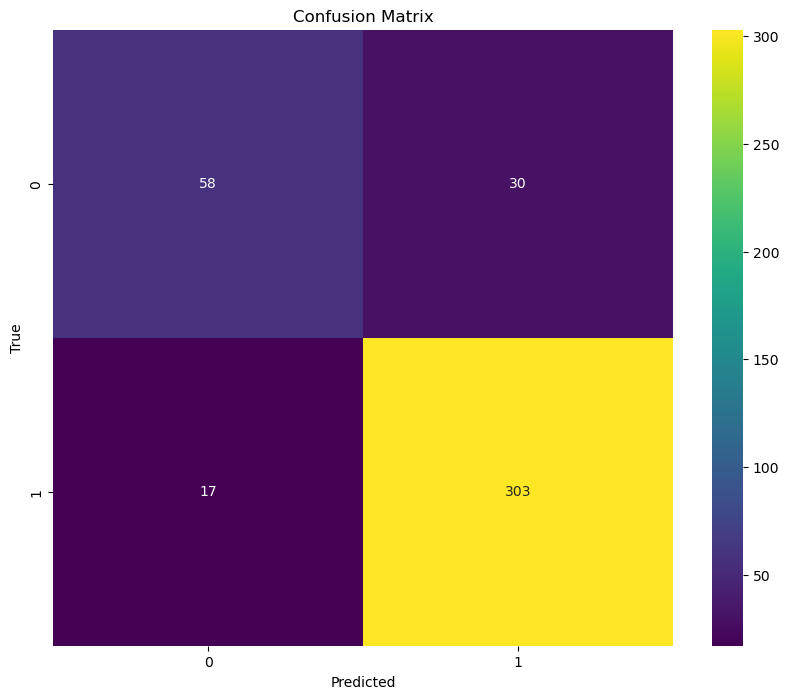

In [21]:
# Calculate confusion matrix
ConfusionMatrix = confusion_matrix(val_res['actual'], val_res['pred'])

# Plot confusion matrix with custom formatting
plt.figure(figsize=(10, 8))

# Use the 'fmt' argument to set the format for annotations
sns.heatmap(ConfusionMatrix, cmap="viridis", annot=True, fmt='g')

plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()